In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d.axes3d import Axes3D
from PIL import Image
import f_class
from GP import GP
from GP_grad import GP_grad
import time
import imageio

In [2]:
Noise = False # Specify if noisy or not
Noise_level = 0.00 # if noisy, what is the noise sd
'''If use the scaled X and y, rememeber to scale the noise as well'''

'If use the scaled X and y, rememeber to scale the noise as well'

In [3]:
objective = f_class.sin(Noise, Noise_level)
objective = f_class.Ackley_1(Noise, Noise_level)
# objective = f_class.Schwefel(Noise, Noise_level, 1)

clean_f = lambda x: f_class.sin().func(x)
clean_f = lambda x: f_class.Ackley_1().func(x)
# clean_f = lambda x: f_class.Schwefel(dim=1).func(x)

B = np.array([item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])], dtype=np.float64)
lb = B[:, 0]; ub = B[:, 1]

f = objective.func
print(f( np.array([2]) ))

dim = objective.input_dim
print('dim: ', dim)

[[0.65935991]]
dim:  1


In [4]:
# max budget for finding good point
Budget = 100

In [5]:
# set seed
seed = 1
def draw(n_random_draws=3):
    X = np.random.uniform(lb, ub, size=(n_random_draws, dim))
    return X, f(X)

def optimize_hyper(lb, ub, sample_size=200):
    
    ls, var = gp.optimize()
    gp.clear()
    return (ls, var)

In [6]:
# # find optimized hyper
# gp = GP_grad(B, Noise, Noise_level, compress=True)

# X = np.asarray(np.random.uniform(lb, ub, size=(1000, dim)))
# gp.set_data(X, f(X))

# (ls, var) = gp.optimize()
# del gp
# (ls, var)

In [7]:
gp = GP_grad(B, Noise, Noise_level, compress=True)

# set optimized hyper
# gp.set_hyper(ls, var)

# put in some random data (let them to be close)
init_size = 5
# X = np.asarray(np.random.uniform(lb, ub, size=(init_size, dim)))
X = np.random.uniform(lb, ub, size=(init_size, dim))

gp.set_data(X, f(X))
gp.optimize()
gp.fit()

array([[ 8.867919  ],
       [ 1.68352823],
       [-0.64135439],
       [-9.35193808],
       [-0.11396296]])

In [8]:
gp._y, gp.y, gp.posterior(X)

(array([[-0.66071563],
        [ 1.94818128],
        [-0.3683838 ],
        [-0.78356425],
        [-0.1355176 ]]),
 array([[0.37590362],
        [0.77070753],
        [0.42014214],
        [0.35731296],
        [0.45538175]]),
 (array([[-0.66071572],
         [ 1.94818126],
         [-0.3683838 ],
         [-0.78356415],
         [-0.13551759]]),
  array([[ 9.99999328e-09, -7.50259433e-19,  3.33066907e-16,
           6.88338275e-15, -1.95156391e-18],
         [-7.50259433e-19,  1.00000004e-08,  4.33680869e-19,
           6.99755094e-19, -1.84192543e-22],
         [ 3.33066907e-16,  4.33680869e-19,  9.99999994e-09,
          -2.77555756e-16,  8.28768799e-20],
         [ 6.88338275e-15,  6.99755094e-19, -2.77555756e-16,
           9.99999350e-09,  1.95156391e-18],
         [-1.95156391e-18, -1.84192543e-22,  8.28768799e-20,
           1.95156391e-18,  9.99999972e-09]])))

In [9]:
# Grid -> test points for plotting
n_Grid = 500
Grid = np.linspace(lb, ub, n_Grid).reshape(-1, dim)

In [10]:
mu, covar = gp.posterior(Grid)
mu = np.squeeze(mu)
s = np.sqrt(np.diag(covar))

Kt = gp.cov_RBF(Grid, Grid, gp.get_hyper())
K_11 = gp.K11(Grid)
K_01 = gp.K01(Grid)

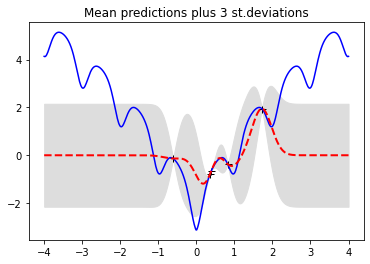

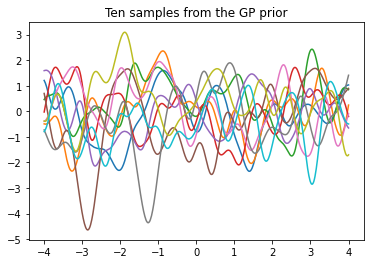

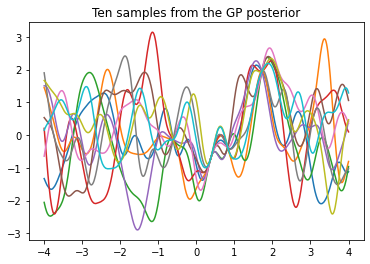

In [11]:
# plot
pl.figure(1)
pl.clf()
pl.plot(gp._X, gp._y, 'k+', ms=7)
pl.plot(Grid, gp._normal(clean_f(Grid)), 'b-')
pl.gca().fill_between(Grid.flat, mu-2*s, mu+2*s, color="#dddddd")

pl.plot(Grid, mu, 'r--', lw=2)
# pl.savefig('predictive.png', bbox_inches='tight')
pl.title('Mean predictions plus 3 st.deviations')

# draw samples from the prior at our test points.
L = np.linalg.cholesky(Kt + 1e-6*np.eye(n_Grid))
f_prior = np.dot(L, np.random.normal(size=(n_Grid, 10)))
pl.figure(2)
pl.clf()
pl.plot(Grid, f_prior)
pl.title('Ten samples from the GP prior')
# pl.savefig('prior.png', bbox_inches='tight')

# draw samples from the posterior at our test points.
L = np.linalg.cholesky(covar + 1e-6*np.eye(n_Grid)) # LL^T = Sigma (posterior covariance)
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n_Grid, 10)))
pl.figure(3)
pl.clf()
pl.plot(Grid, f_post)
pl.title('Ten samples from the GP posterior')
# pl.savefig('post.png', bbox_inches='tight')

pl.show()

In [12]:
mu_grad, covar_grad = gp.posterior_grad(Grid)
s_grad = np.sqrt(np.diag(covar_grad))
mu_grad = np.squeeze(mu_grad)

In [13]:
from scipy import optimize

# optimize.approx_fprime(x, clean_Ackley_1d, eps)
eps = np.sqrt(np.finfo(float).eps)
approx_grad = [optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid]

In [14]:
gp.get_normal()

(0.47588960026097016, 0.15132982592390104)

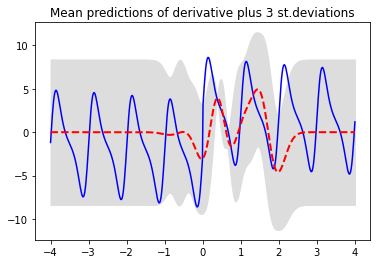

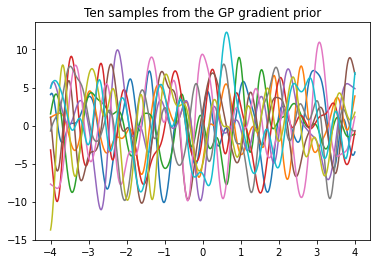

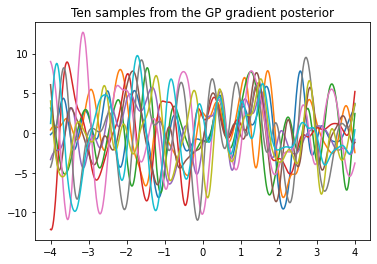

In [15]:
# plot
pl.figure(1)
pl.clf()
# pl.plot(X, y, 'r+', ms=7)
pl.plot(Grid, gp._normal_grad(approx_grad), 'b-')
pl.gca().fill_between(Grid.flat, mu_grad-2*s_grad, mu_grad+2*s_grad, color="#dddddd")

pl.plot(Grid, mu_grad, 'r--', lw=2)
pl.savefig('predictive_grad.png', bbox_inches='tight')
pl.title('Mean predictions of derivative plus 3 st.deviations')

# draw samples from the prior at our test points.
L = np.linalg.cholesky(K_11 + 1e-6*np.eye(n_Grid))
f_prior = np.dot(L, np.random.normal(size=(n_Grid, 10)))
pl.figure(2)
pl.clf()
pl.plot(Grid, f_prior)
pl.title('Ten samples from the GP gradient prior')
pl.savefig('prior_grad.png', bbox_inches='tight')

# draw samples from the posterior at our test points.
L = np.linalg.cholesky(covar_grad + 1e-6*np.eye(n_Grid)) # LL^T = Sigma (posterior covariance)
f_post = mu_grad.reshape(-1,1) + np.dot(L, np.random.normal(size=(n_Grid, 10)))
pl.figure(3)
pl.clf()
pl.plot(Grid, f_post)
pl.title('Ten samples from the GP gradient posterior')
pl.savefig('post_grad.png', bbox_inches='tight')

pl.show()

### Gradient Descent 

In [16]:
n_iter = 20
lr = 0.5
lr_init = 15
alpha = 0.5

history = []
history_lr = []


# w = X[0].reshape(1, -1) 
arg_min = np.argmin(f(X))
w = X[arg_min].reshape(1, -1) # min value to start
w

array([[0.35906546]])

In [17]:
gp.posterior_grad(w), gp._normal_grad(optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps))

((array([[3.83479099]]), array([[0.09767788]])), array([4.16722266]))

In [18]:
gp.get_normal()

(0.47588960026097016, 0.15132982592390104)

In [19]:
# for Adam
epsilon = 1e-8
b1 = 0.9
b2 = 0.999
lr = 0.01
mt = np.array([0])
vt = np.array([0])

`Backtrack`
$$F(x_n + \eta \times d_n) < F(x_n) + \alpha \times \eta \times \langle d_n, \nabla F(x_n)\rangle$$

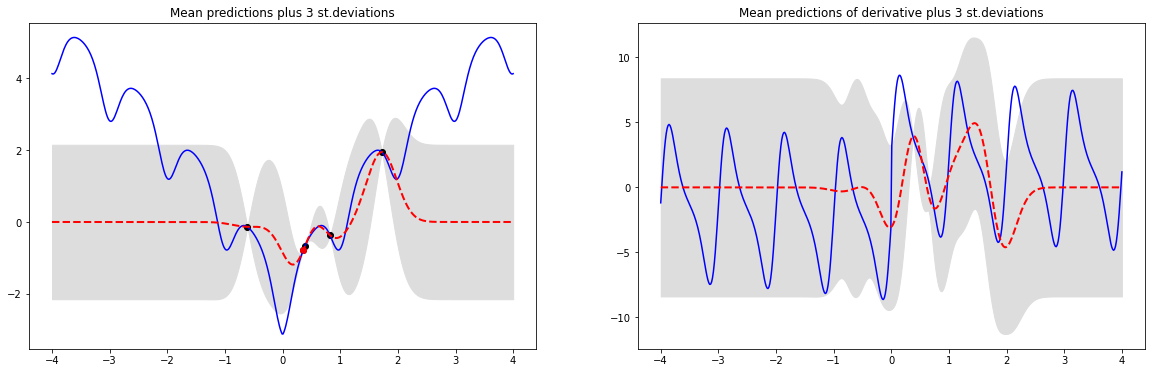

w:  [[0.32071755]]
lr:  0.01
df: [[3.40903058]], s.d. [[1.19786264]]
actual df [4.91800415]
  # Optimal (ls, var) =  (0.3401840019158827, 1.8694852687842751)


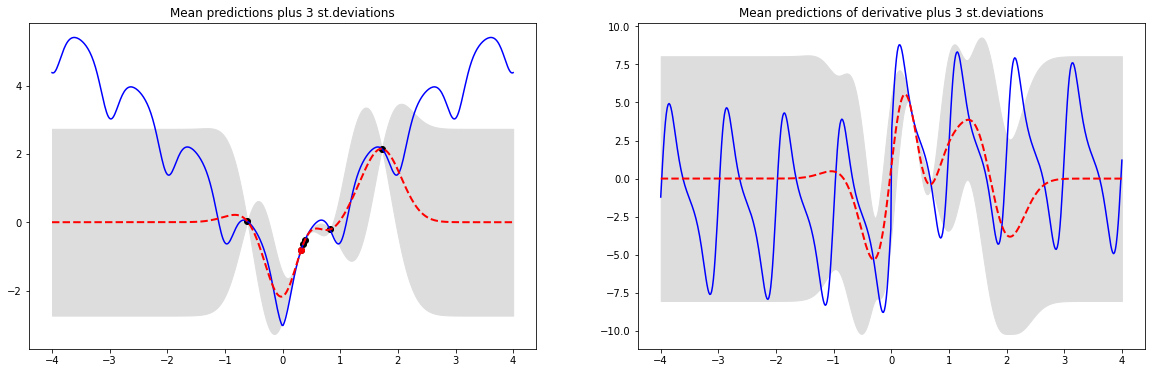

w:  [[0.27148503]]
lr:  0.01
df: [[5.43571761]], s.d. [[0.04102843]]
actual df [6.2235002]


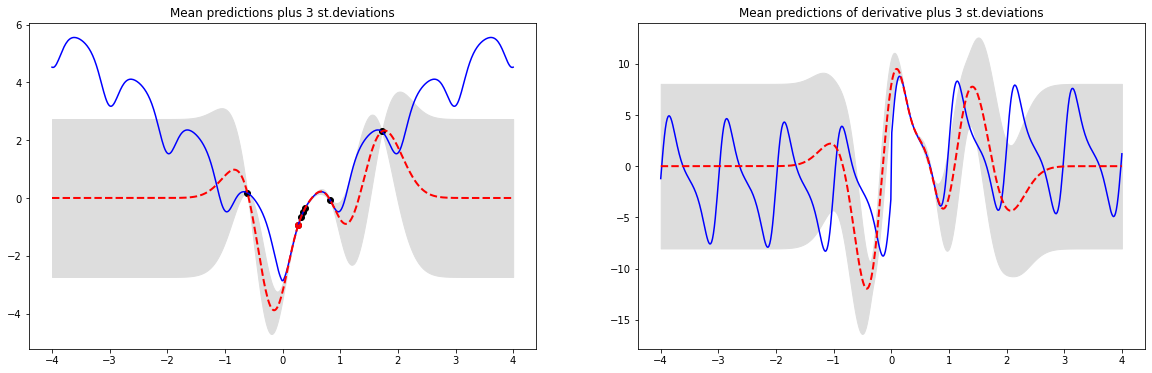

w:  [[0.20945917]]
lr:  0.01
df: [[7.80004693]], s.d. [[0.01157441]]
actual df [7.8506211]


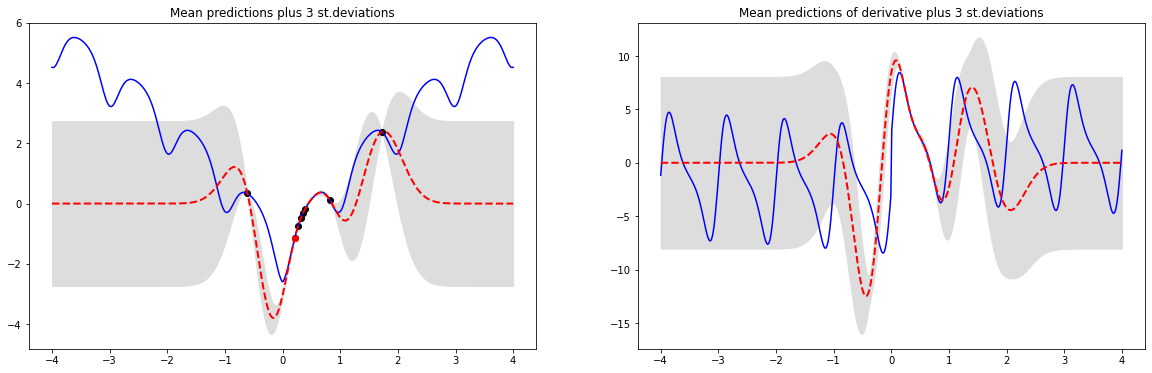

w:  [[0.1336364]]
lr:  0.01
df: [[9.18301621]], s.d. [[0.0208277]]
actual df [8.43156775]


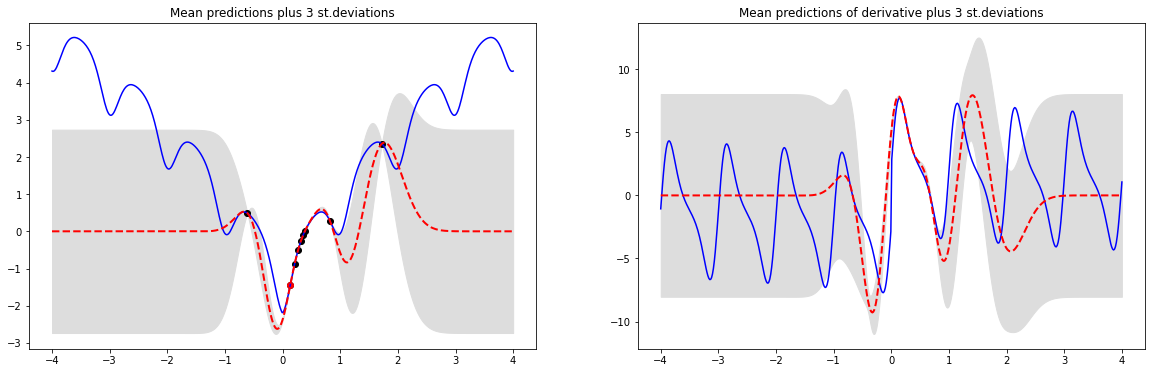

w:  [[0.05524151]]
lr:  0.01
df: [[7.02123297]], s.d. [[0.01431379]]
actual df [5.57854102]


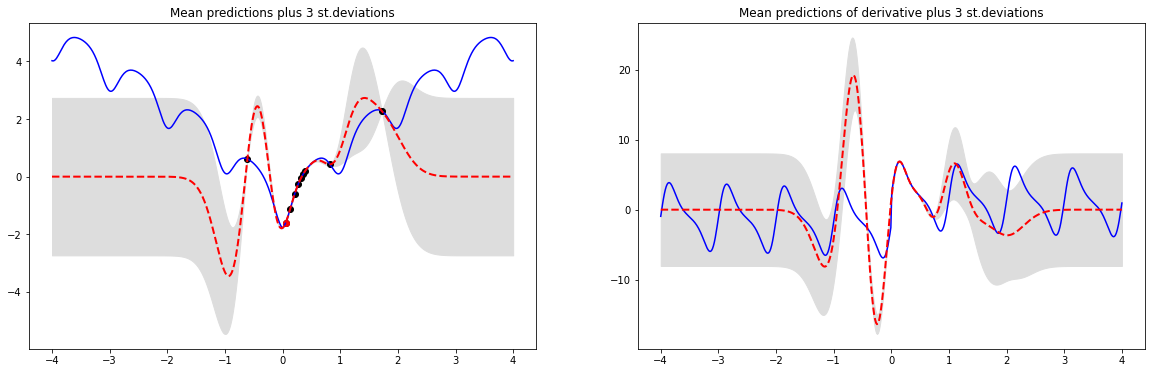

w:  [[0.00558673]]
lr:  0.01
df: [[1.94840556]], s.d. [[0.00307178]]
actual df [2.42756604]
  # Optimal (ls, var) =  (0.248876797825601, 1.3946131863788778)


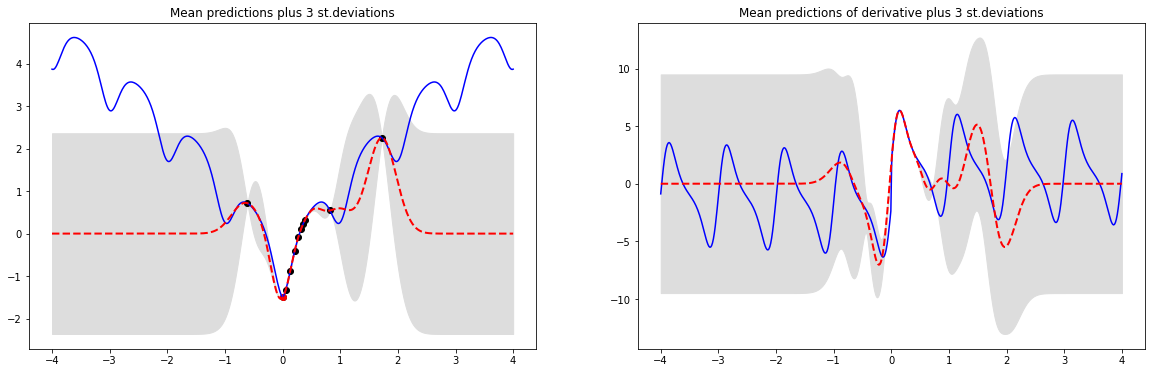

w:  [[-0.01613748]]
lr:  0.01
df: [[0.8820629]], s.d. [[0.00143273]]
actual df [-2.786541]


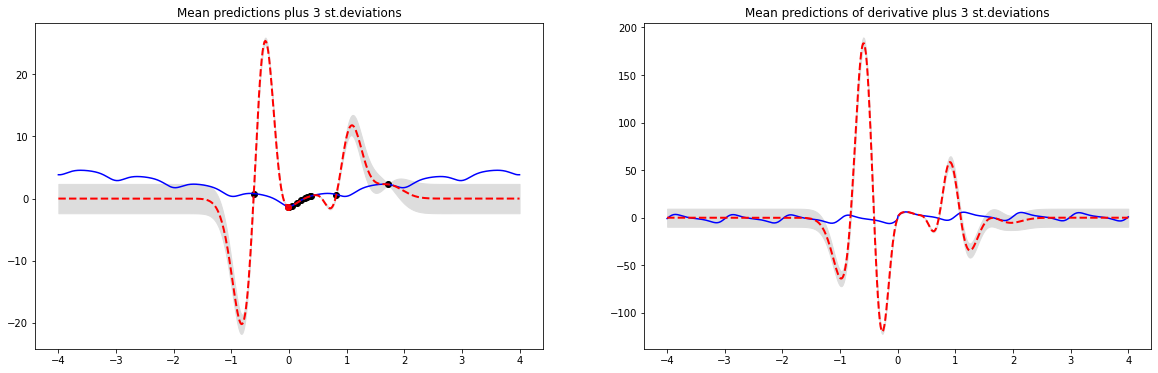

w:  [[0.01259358]]
lr:  0.01
df: [[1.67617587]], s.d. [[6.82344601e-06]]
actual df [2.50517732]


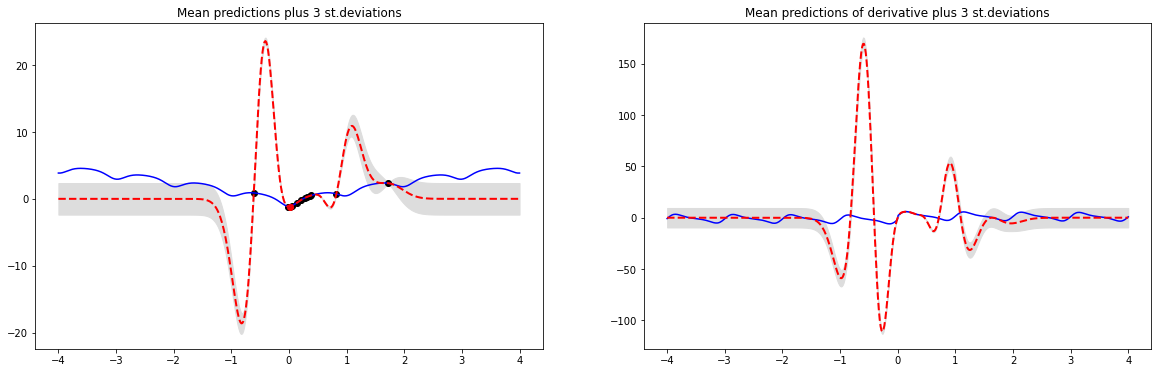

w:  [[-0.00383849]]
lr:  0.01
df: [[-0.52909499]], s.d. [[2.06950206e-05]]
actual df [-2.02600188]


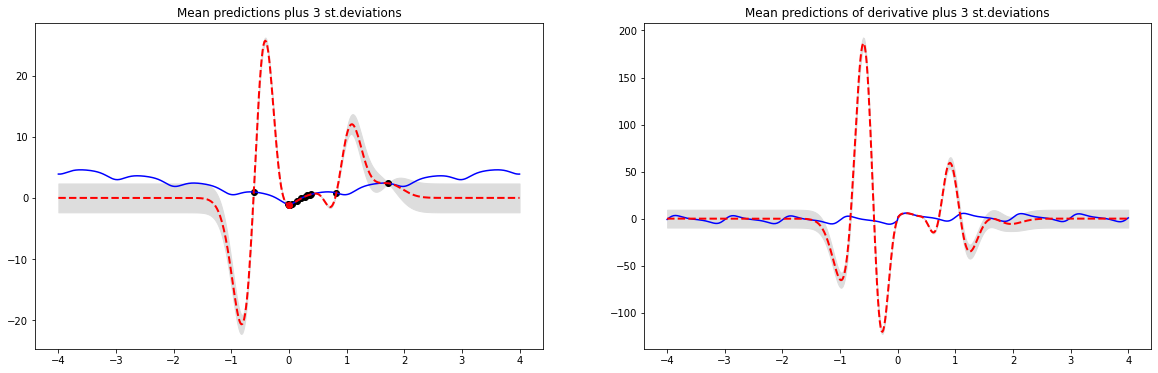

w:  [[0.0013453]]
lr:  0.01
df: [[0.25551771]], s.d. [[1.16198634e-05]]
actual df [1.88184511]


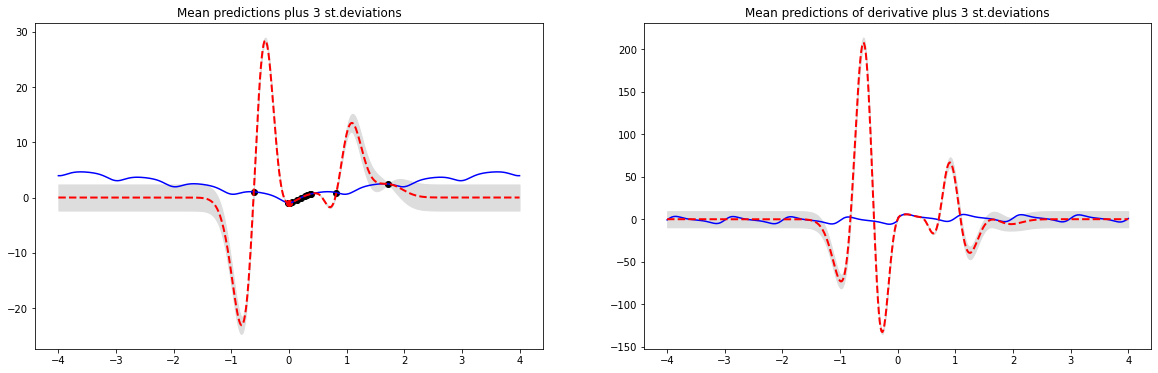

w:  [[-0.00094237]]
lr:  0.01
df: [[-0.11599083]], s.d. [[1.45883144e-05]]
actual df [-1.85386347]
  # Optimal (ls, var) =  (0.11033500469966165, 65.44869937830235)


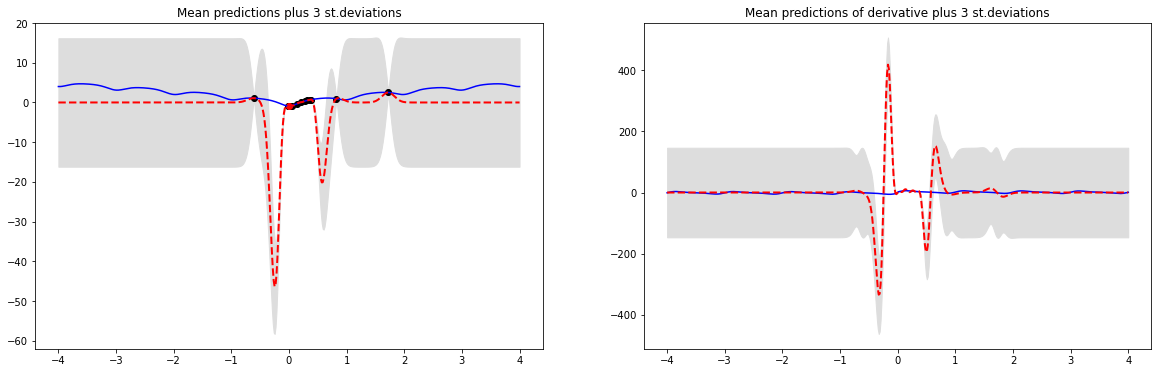

w:  [[-0.00132617]]
lr:  0.01
df: [[-0.06831397]], s.d. [[0.00021897]]
actual df [-1.87305367]


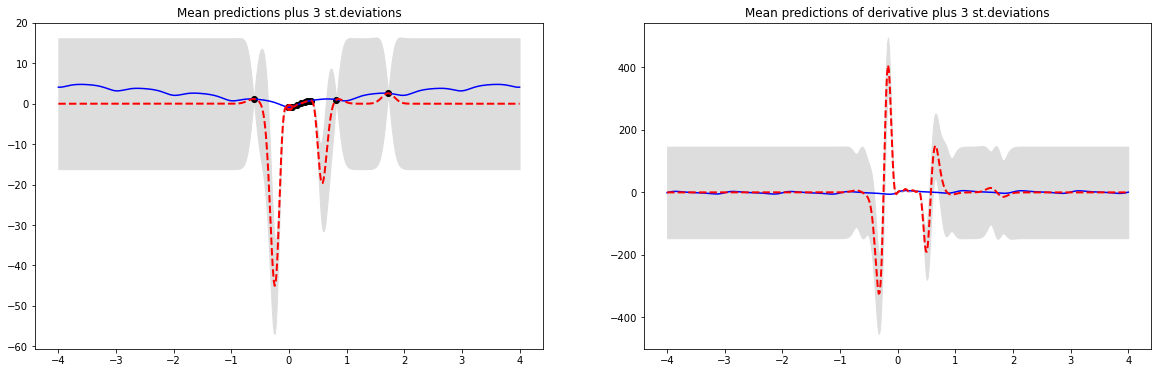

w:  [[-0.00085958]]
lr:  0.01
df: [[0.08445333]], s.d. [[0.00020185]]
actual df [-1.8576374]


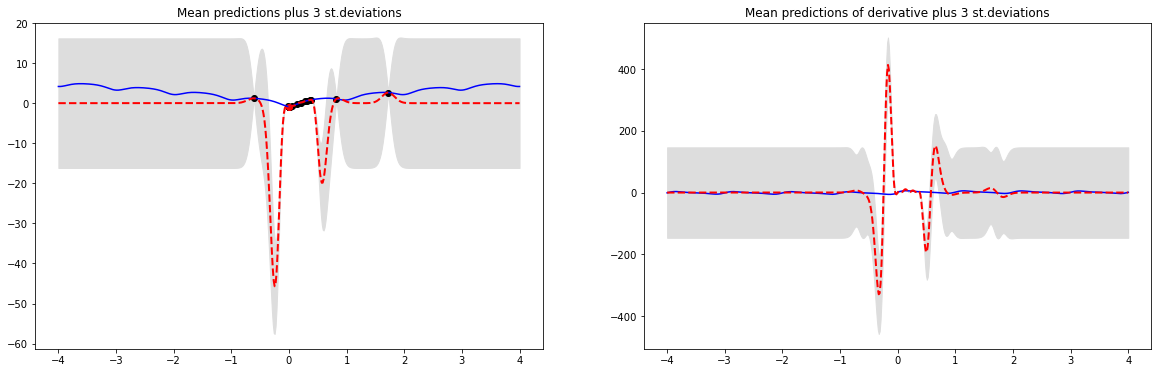

w:  [[-0.00185085]]
lr:  0.01
df: [[-0.18602425]], s.d. [[0.00022626]]
actual df [-1.91723033]


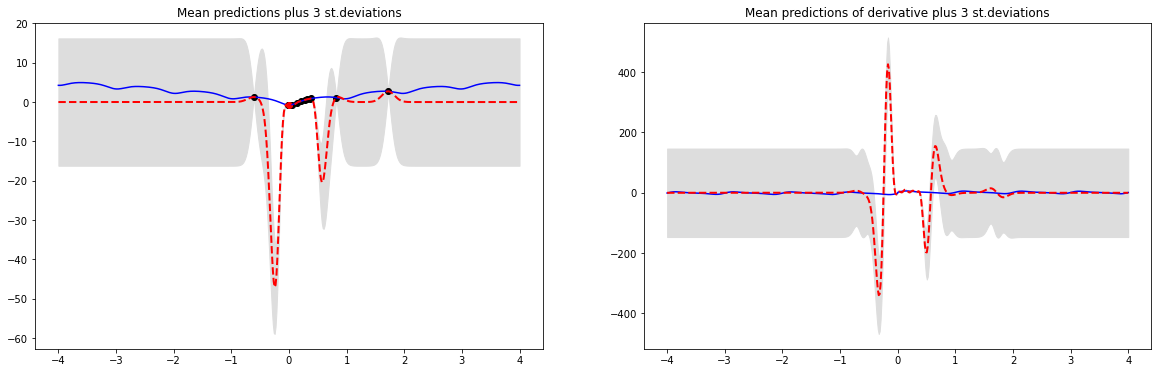

w:  [[0.00011154]]
lr:  0.01
df: [[0.36690729]], s.d. [[0.00016437]]
actual df [1.84701269]


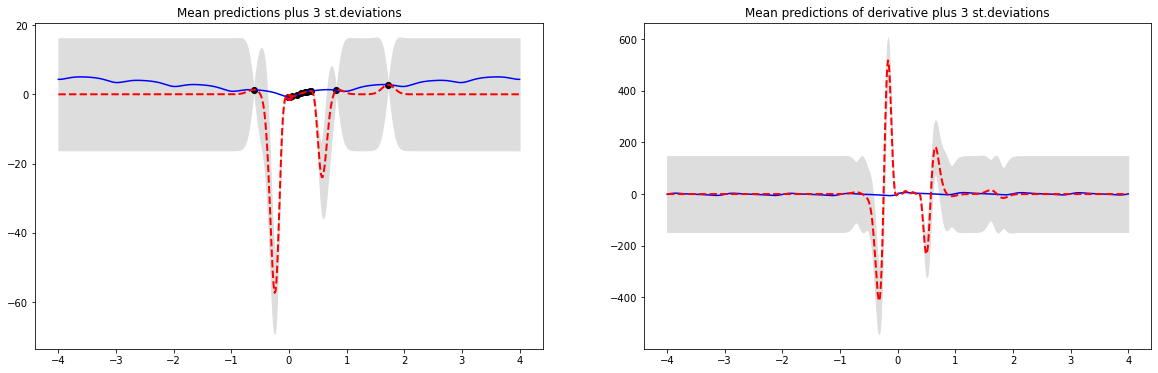

w:  [[-0.00327774]]
lr:  0.01
df: [[-0.68028952]], s.d. [[0.0002367]]
actual df [-2.02000346]
  # Optimal (ls, var) =  (0.07043890965874079, 13.028880354878634)


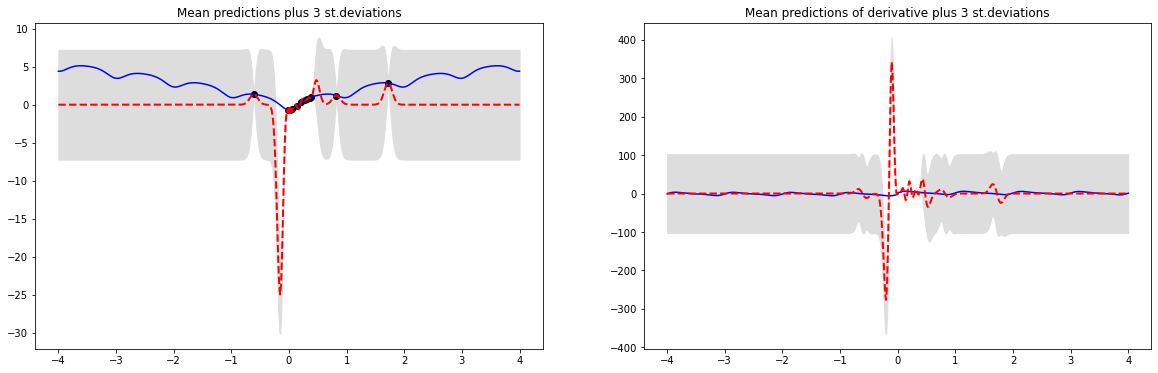

w:  [[0.00869797]]
lr:  0.01
df: [[2.83440352]], s.d. [[0.00022373]]
actual df [2.31006398]


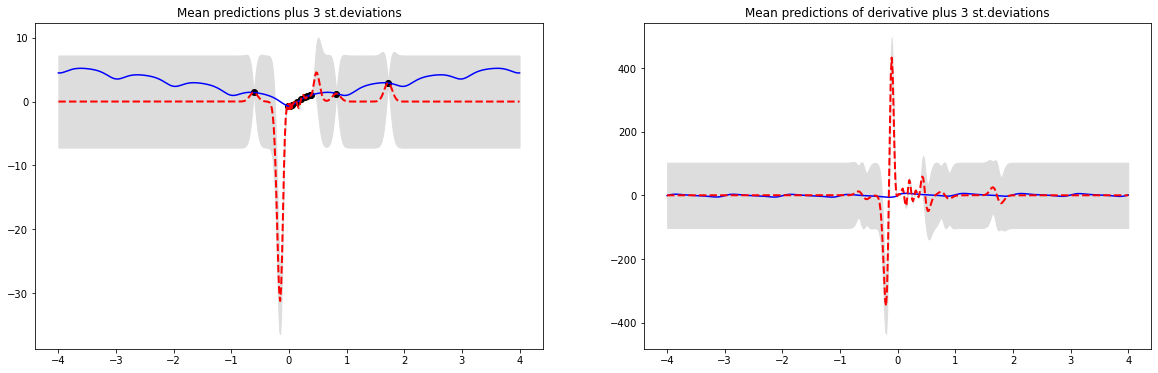

w:  [[-0.01986264]]
lr:  0.01
df: [[-0.80154619]], s.d. [[0.03510349]]
actual df [-2.88954314]


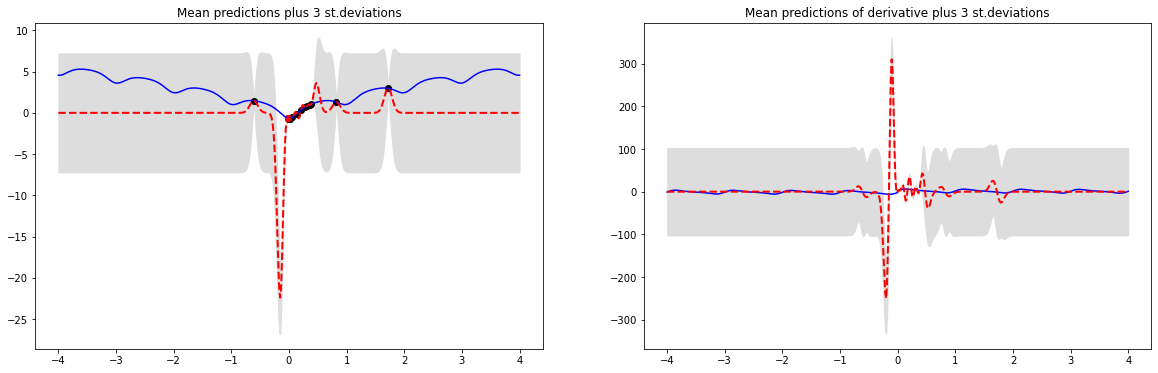

w:  [[0.00045811]]
lr:  0.01
df: [[0.30647394]], s.d. [[0.00012378]]
actual df [1.94307149]


In [20]:
v = np.array([[0]])
for i in range(1,  n_iter):
    # posterior of GP given gp.X, gp.y
    mu, covar = gp.posterior(Grid)
    s = np.sqrt(np.diag(covar))
    mu = np.squeeze(mu)

    # posterior of GP derivative given gp.X, gp.y
    mu_grad, covar_grad = gp.posterior_grad(Grid)
    s_grad = np.sqrt(np.diag(covar_grad))
    mu_grad = np.squeeze(mu_grad)
    
    # joint MVN
    K = gp.cov_RBF(gp._X, gp._X, gp.get_hyper())
    K_ = gp.cov_RBF(Grid, Grid, gp.get_hyper())
    K_11 = gp.K11(Grid)
    K_01 = gp.K01(Grid)

    fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(20, 6))

    # plot function
    ax1.plot(gp._X, gp._y, 'ko')
    ax1.plot(w, gp._normal(f(w)), 'ro')
    
    ax1.plot(Grid.flat, gp._normal(clean_f(Grid)), 'b-')
    ax1.fill_between(Grid.flat, mu-2*s, mu+2*s, color="#dddddd")

    ax1.plot(Grid, mu, 'r--', lw=2)
#     fig.savefig('predictive.png', bbox_inches='tight')
    ax1.set_title('Mean predictions plus 3 st.deviations')

    # plot derivative
    ax2.plot(Grid.flat, gp._normal_grad(approx_grad), 'b-')
    ax2.fill_between(Grid.flat, mu_grad-2*s_grad, mu_grad+2*s_grad, color="#dddddd")

    ax2.plot(Grid.flat, mu_grad, 'r--', lw=2)
    fig.savefig('predictive_grad.png', bbox_inches='tight')
    ax2.set_title('Mean predictions of derivative plus 3 st.deviations')

    pl.show()  

    # 1. gradient descent
    w = np.clip(w - lr * gp.grad(w), gp._B[:, 0], gp._B[:, 1])
    
    #     2. nesterov
#     lr = 0.01
#     v = 0.9*v + lr*grad(gp, w-0.9*v)
#     w = np.clip(w - v, lb, ub)
    
    # 3. Adam
    # approximate first and second moment
#     gt = grad(gp, w)
#     mt = b1 * mt + (1 - b1) * gt
#     vt = b2 * vt + (1 - b2) * np.square(gt)

#     # bias corrected moment estimates
#     mhat = mt / (1 - b1 ** i )
#     vhat = vt / (1 - b2 ** i )

#     # update the params
#     delta_w = -1 * lr * mhat/(np.sqrt(vhat) + epsilon)
#     w = w + delta_w
    
    print('w: ', w)
    print('lr: ', lr)
    m, v = gp.posterior_grad(w)
    print('df:', m, end=', ')
    print('s.d.', v)
    print('actual df', gp._normal_grad(optimize.approx_fprime(w[0], lambda x: clean_f(x).item(), eps)) )
#     print('desc:', -gt)
    history.append( f(w) )
    history_lr.append(lr)
    gp.add_data(w, f(w))
    if i % 5 == 1:
        ls, var = gp.optimize()
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()

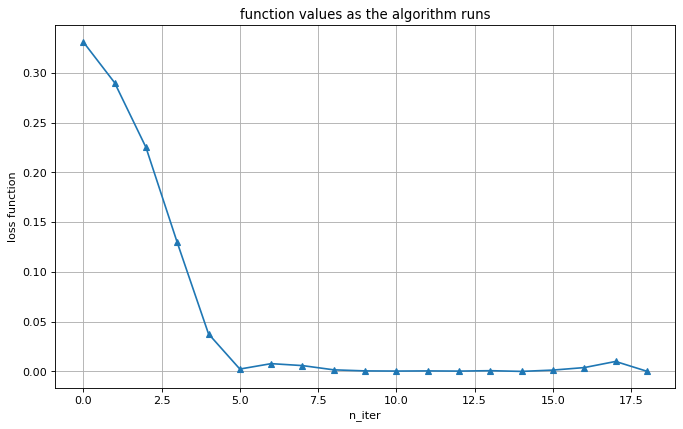

In [21]:
pl.figure(figsize=(10, 6), dpi=80)
pl.plot(np.squeeze(history), "-^")
pl.title("function values as the algorithm runs")
pl.xlabel("n_iter")
pl.ylabel("loss function")
pl.grid(True)

In [22]:
# plot lr
# pl.figure(figsize=(10, 6), dpi=80)
# pl.plot(history_lr, "-^")
# pl.title("learning rate as the algorithm runs")
# pl.xlabel("n_iter")
# pl.ylabel("learning rate")
# pl.yscale("log")
# pl.grid(True)

### Thompson Sampling

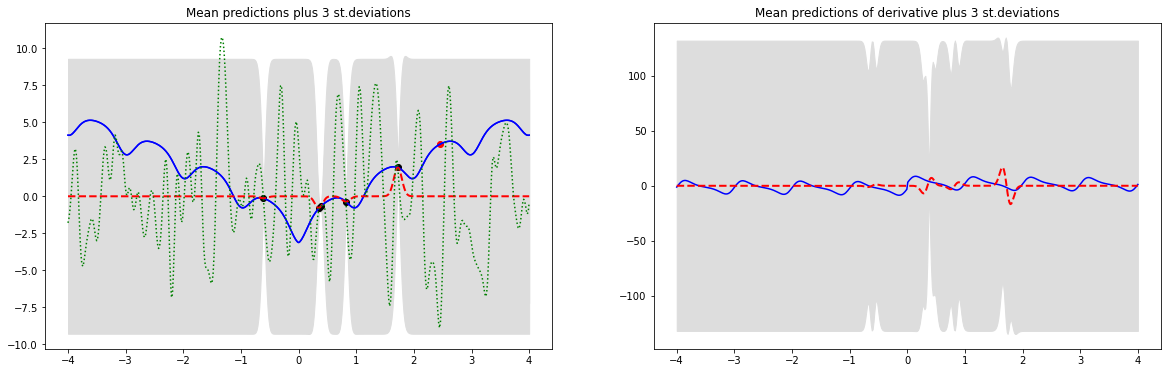

w:  [2.44488978]


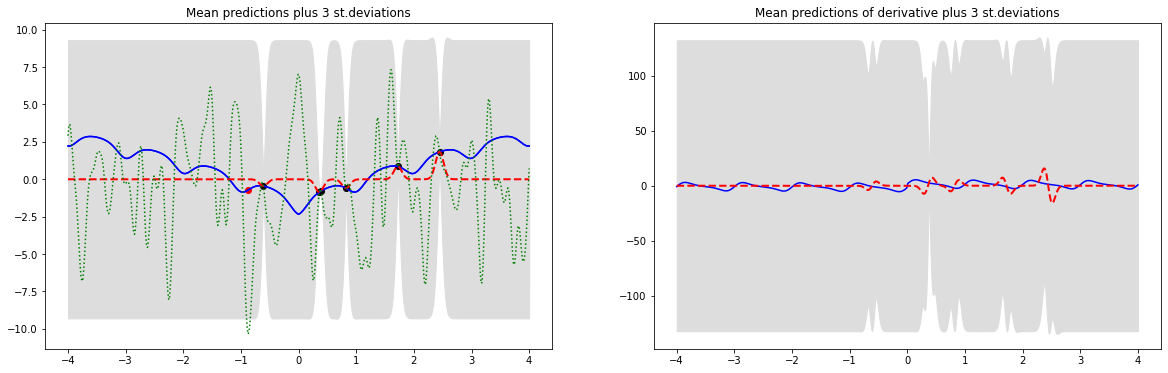

w:  [-0.87374749]


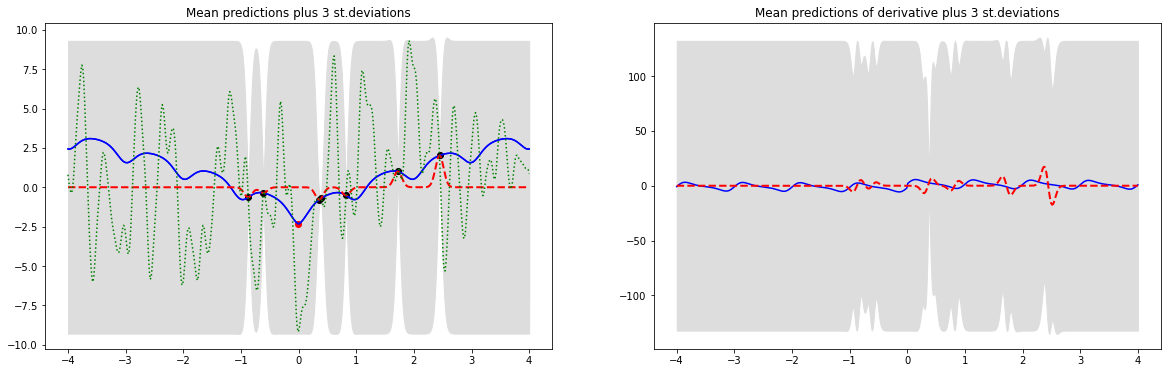

w:  [-0.00801603]


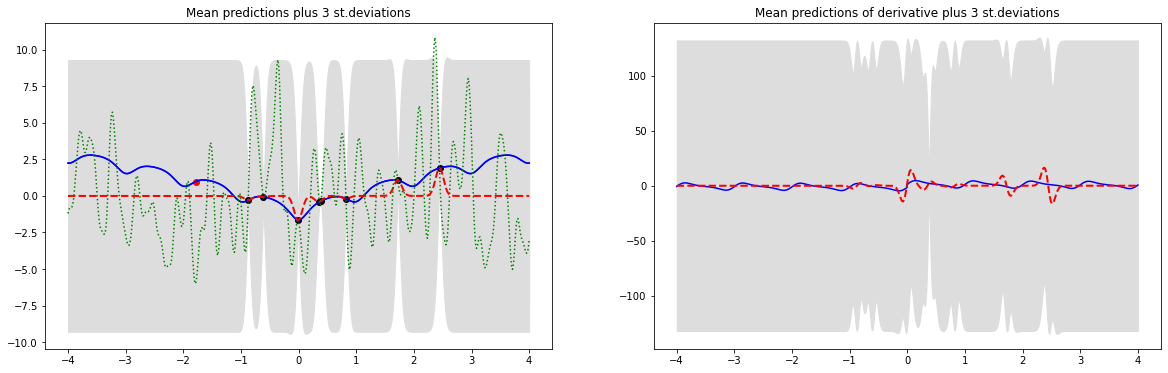

w:  [-1.78757515]


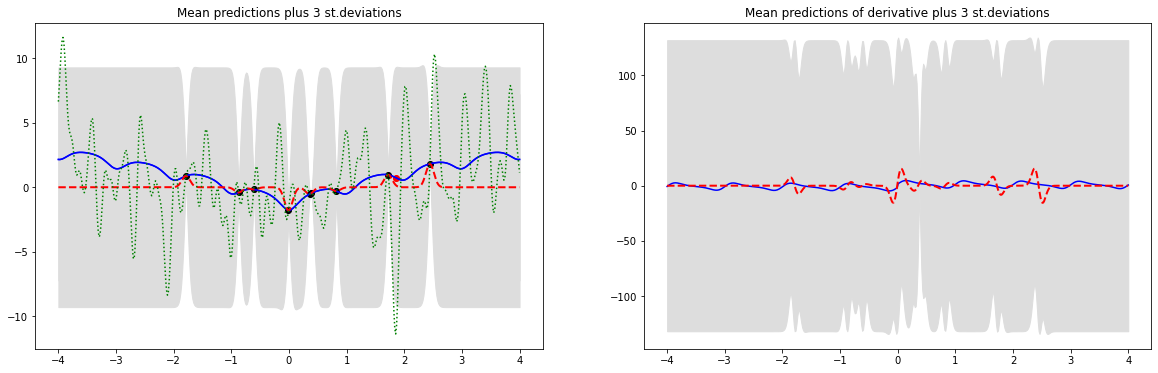

w:  [1.85170341]


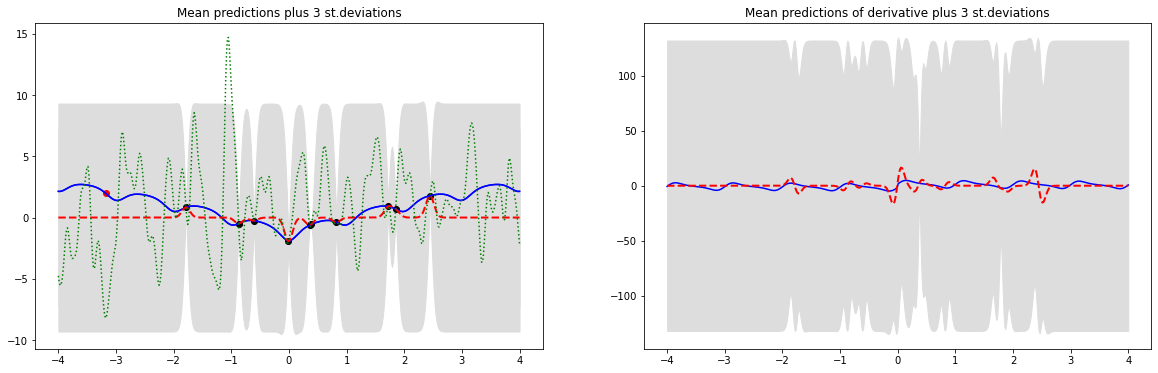

w:  [-3.18236473]


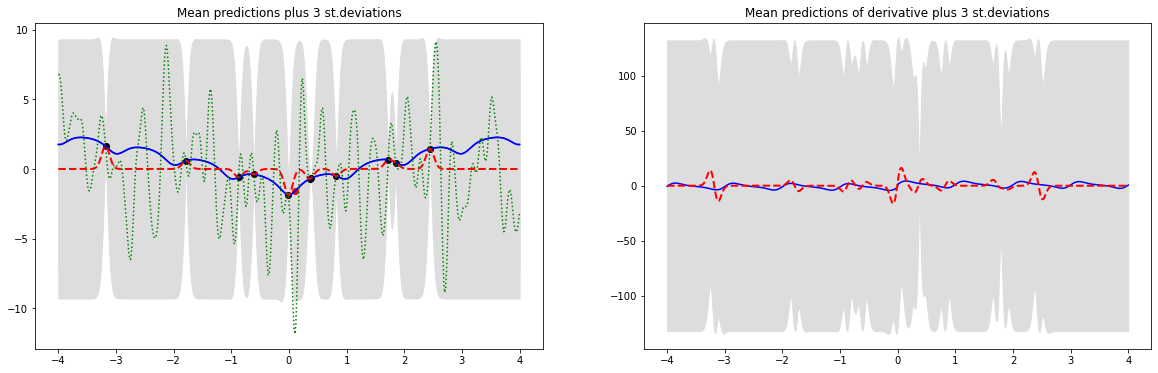

w:  [0.10420842]


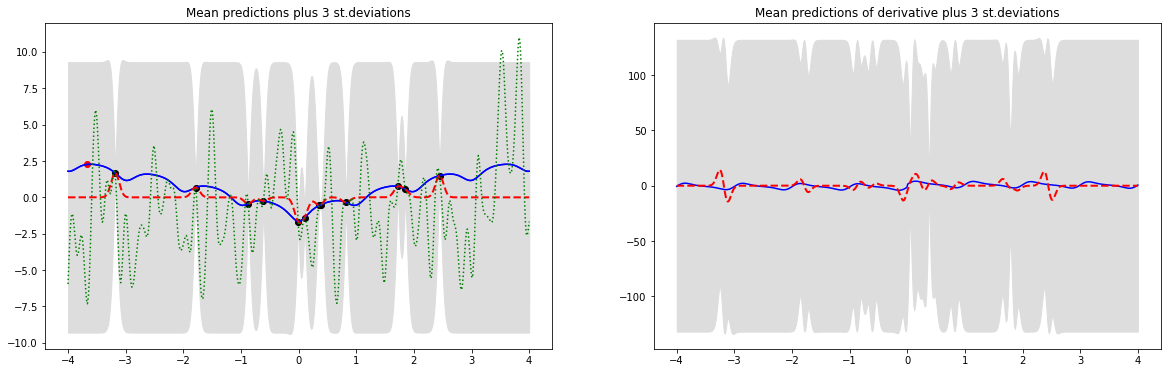

w:  [-3.66332665]


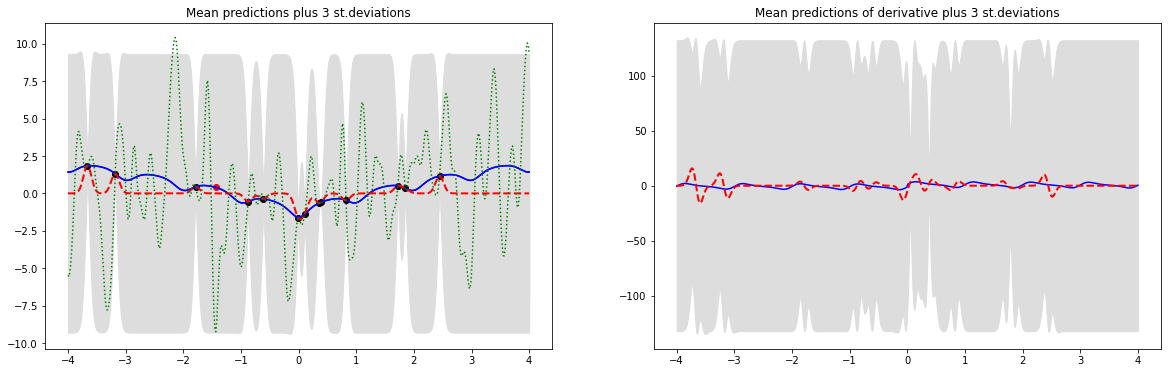

w:  [-1.43486974]


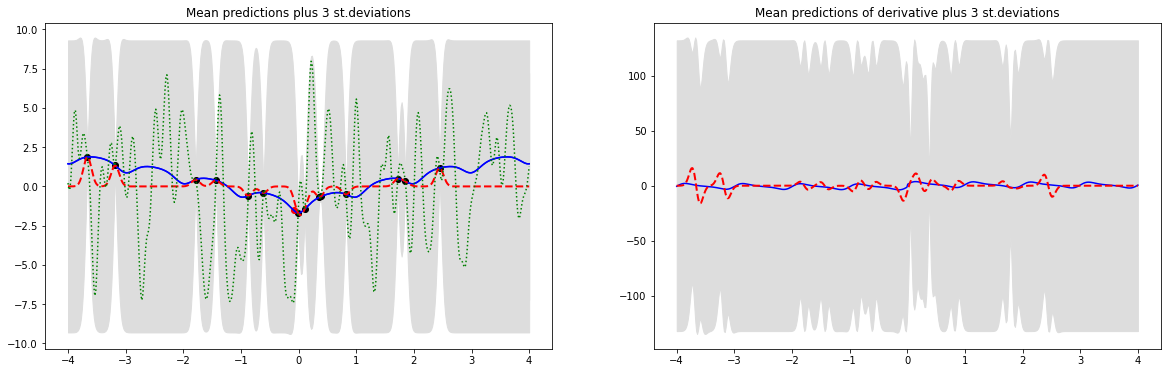

w:  [-0.08817635]


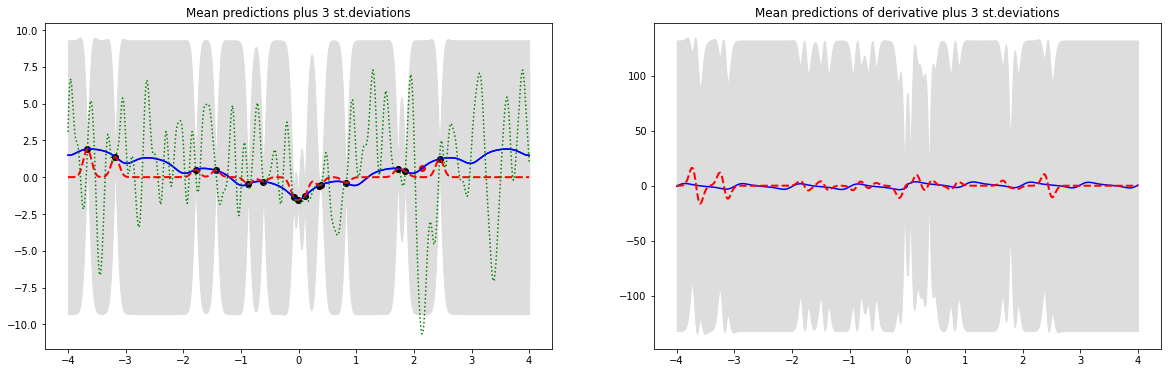

w:  [2.14028056]


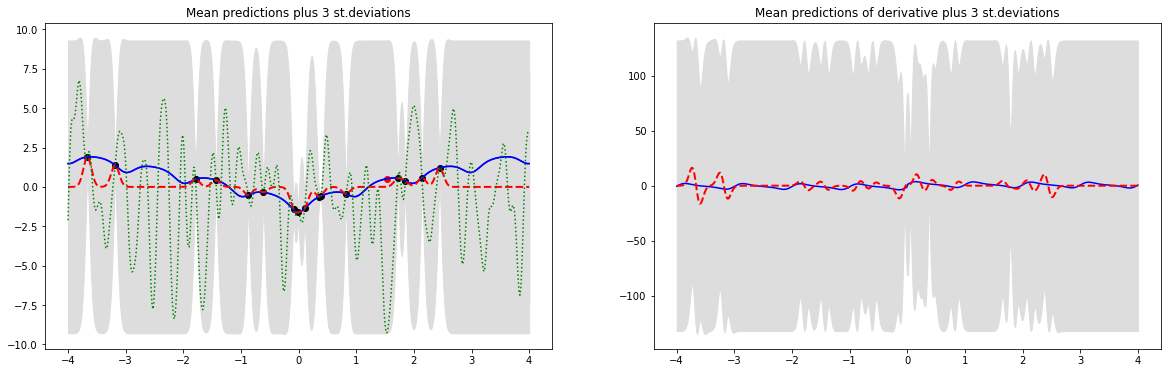

w:  [1.53106212]


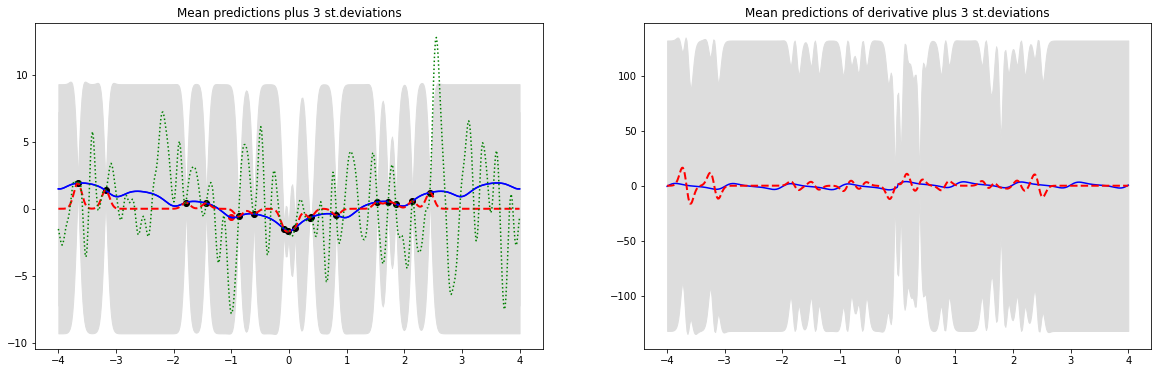

w:  [-1.00200401]


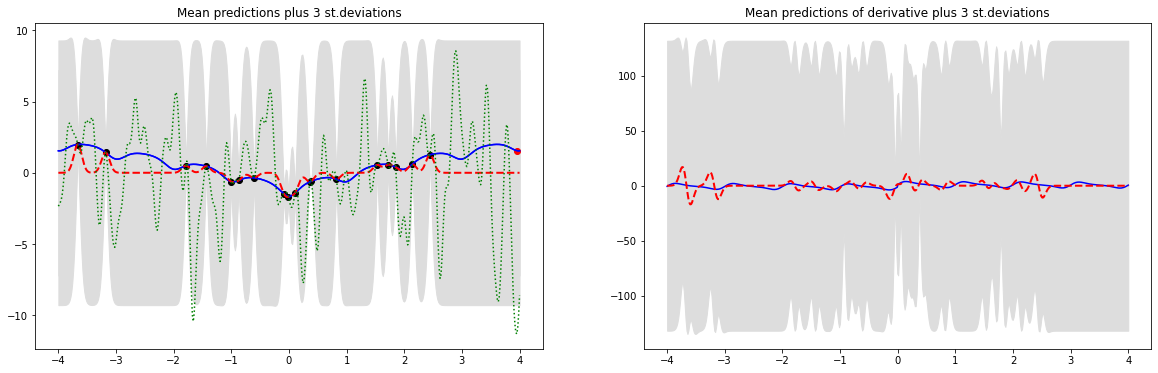

w:  [3.95190381]


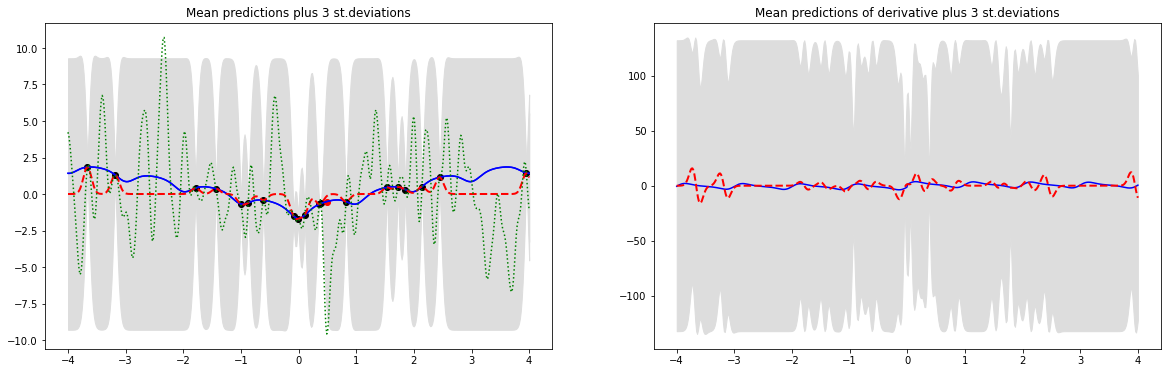

w:  [0.48897796]


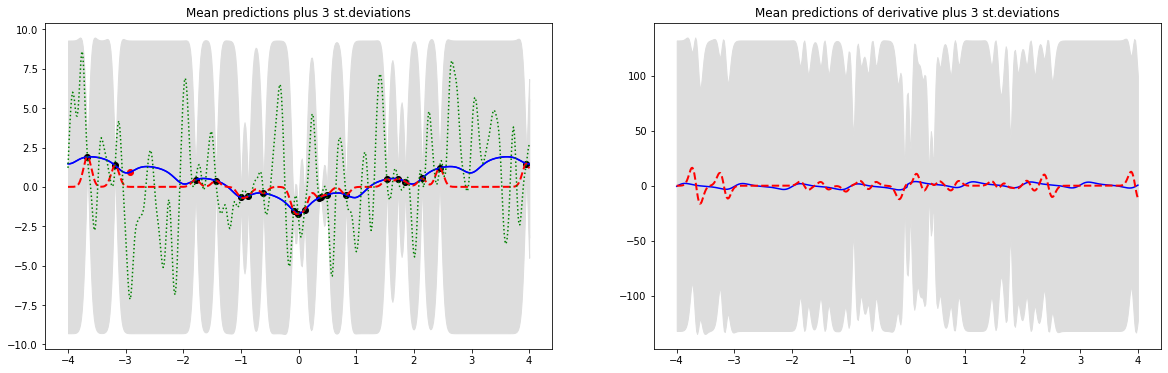

w:  [-2.9258517]


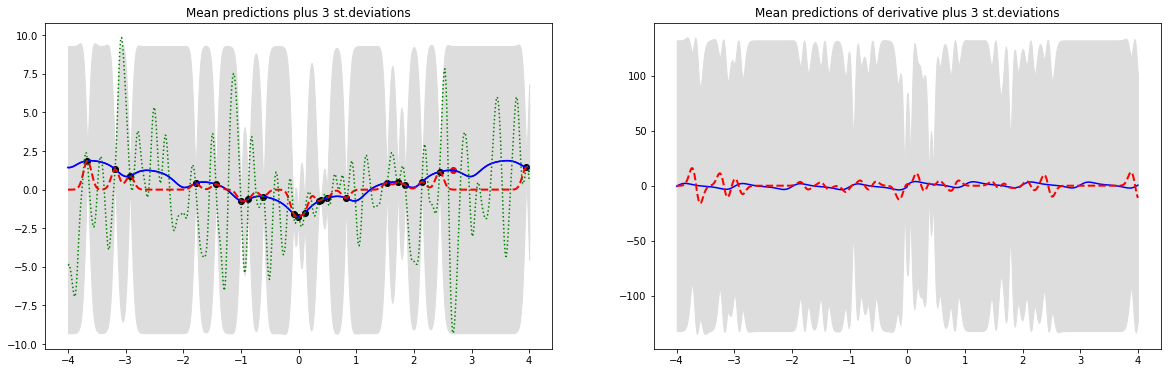

w:  [2.68537074]


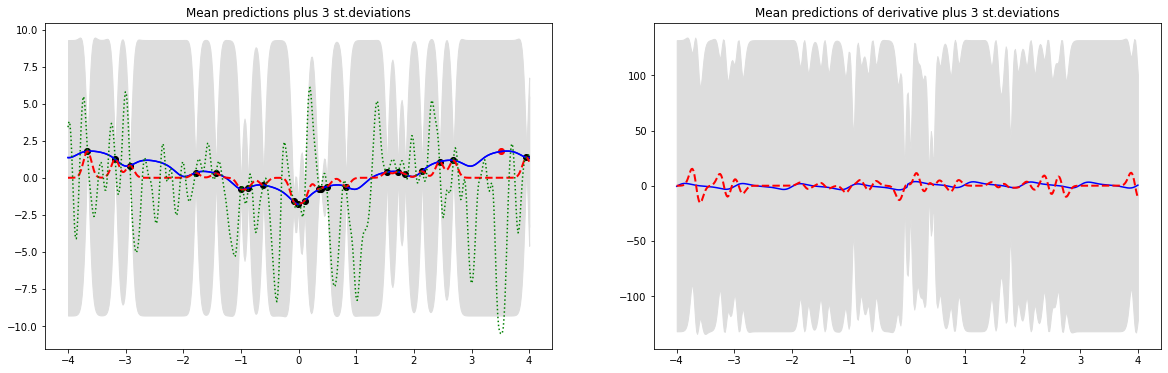

w:  [3.51903808]


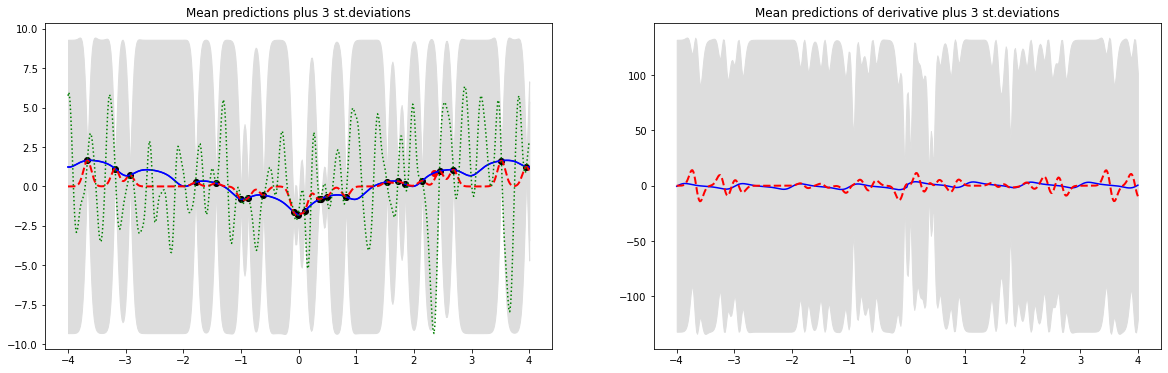

w:  [2.34869739]


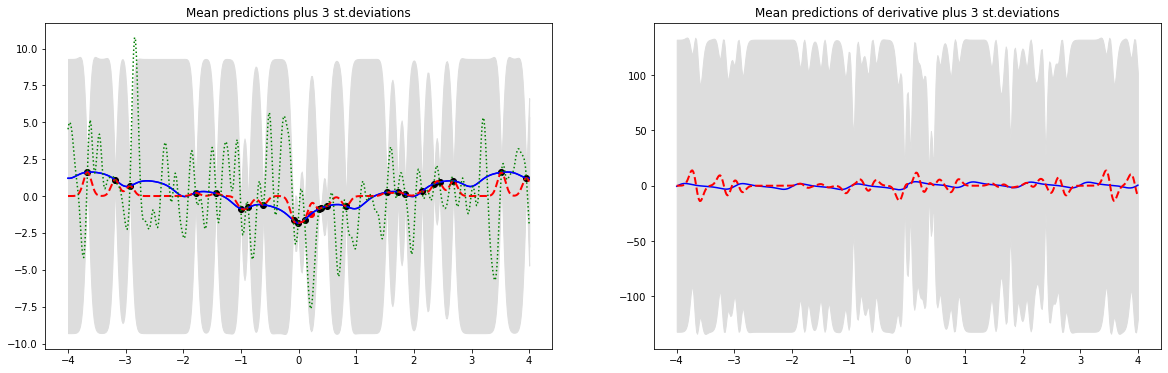

w:  [0.21643287]


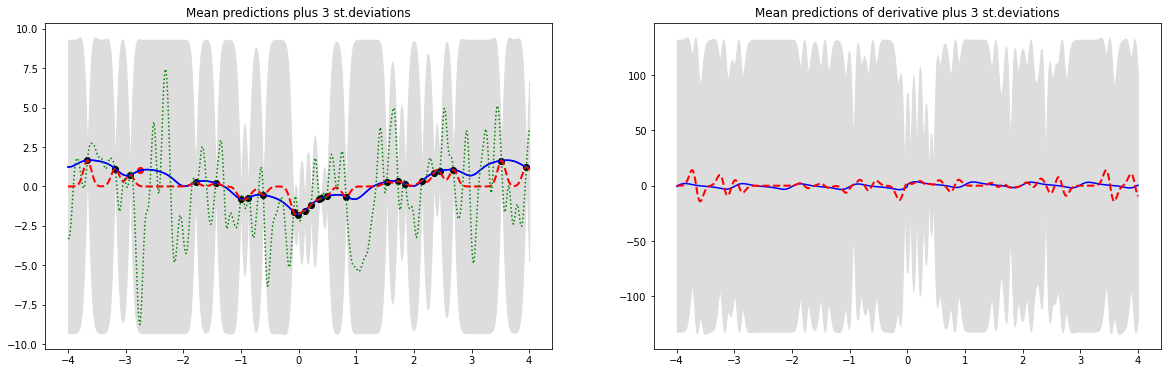

w:  [-2.749499]


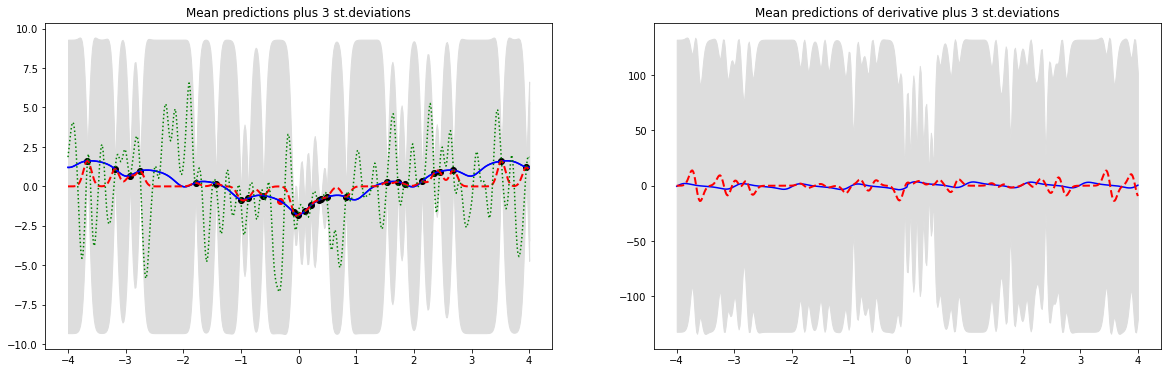

w:  [-0.32865731]


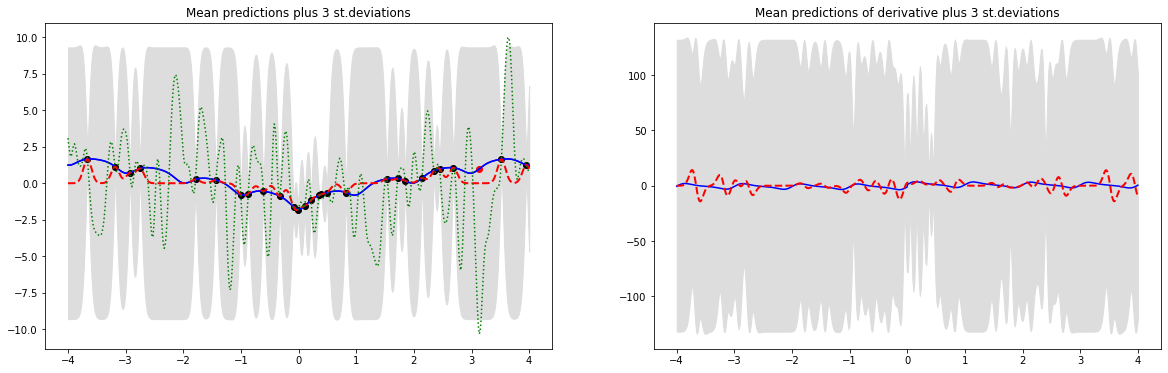

w:  [3.13426854]


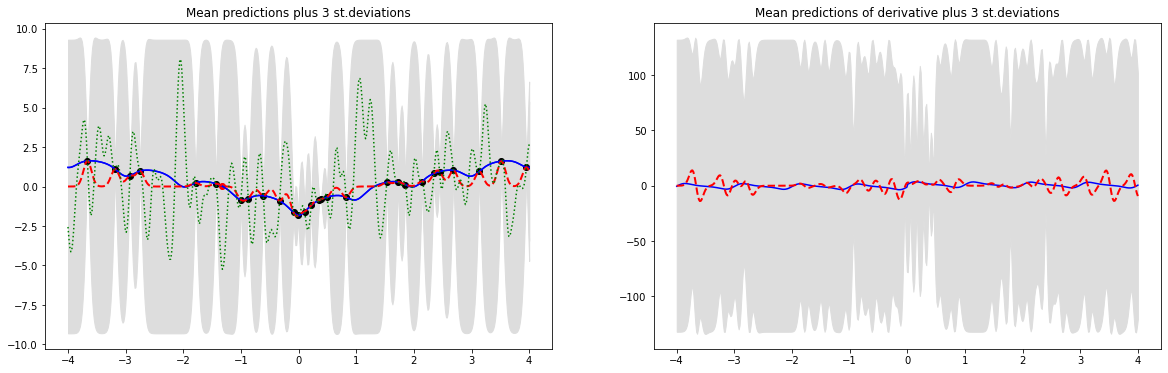

w:  [-1.32264529]


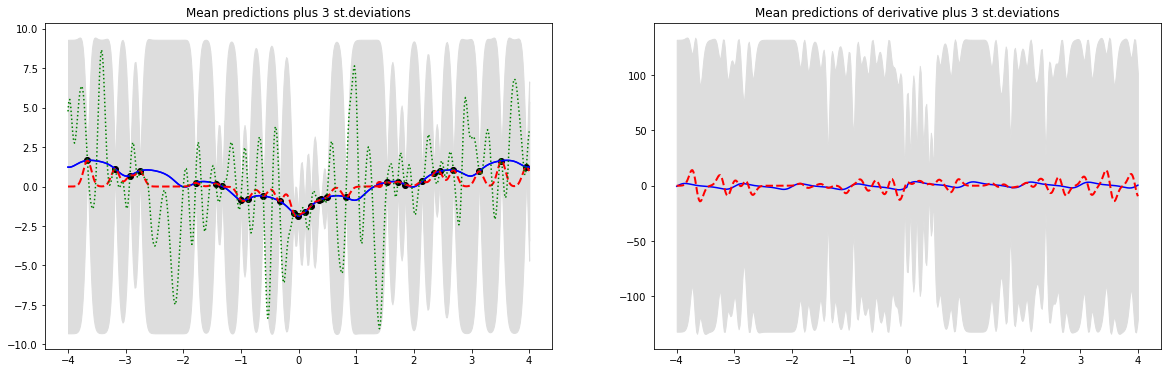

w:  [1.40280561]


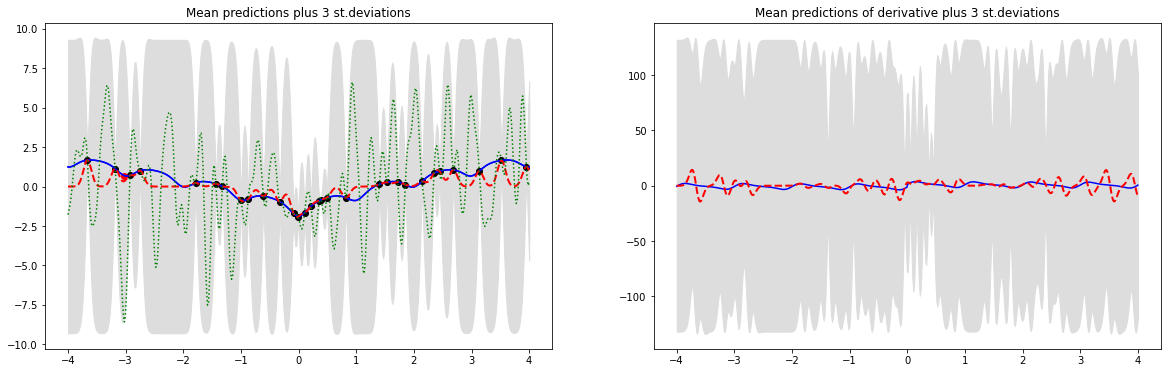

w:  [-3.02204409]


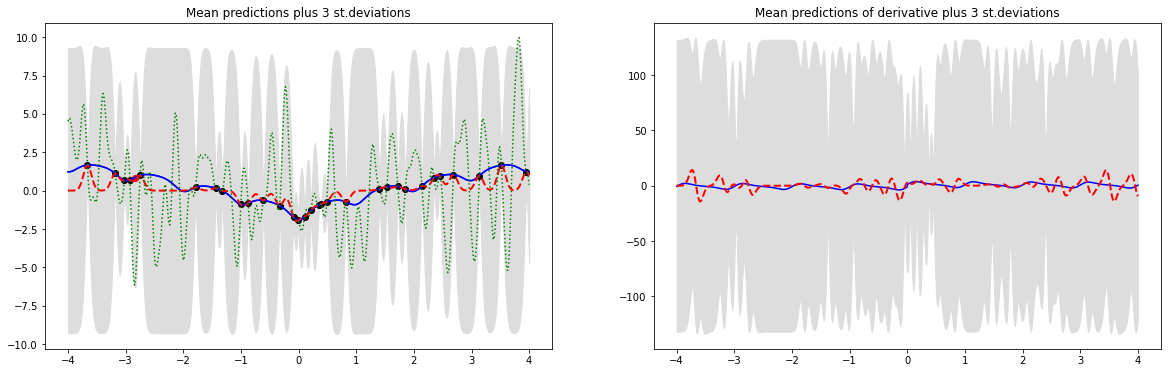

w:  [-2.84569138]


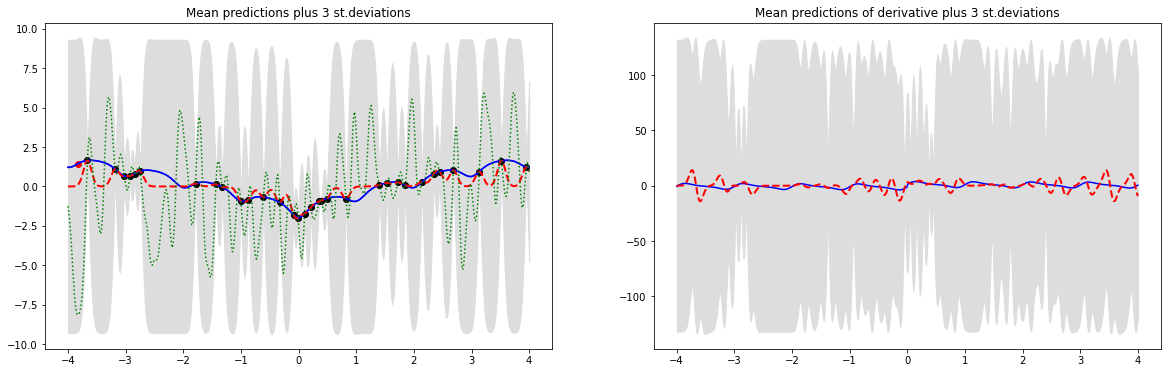

w:  [-3.82364729]


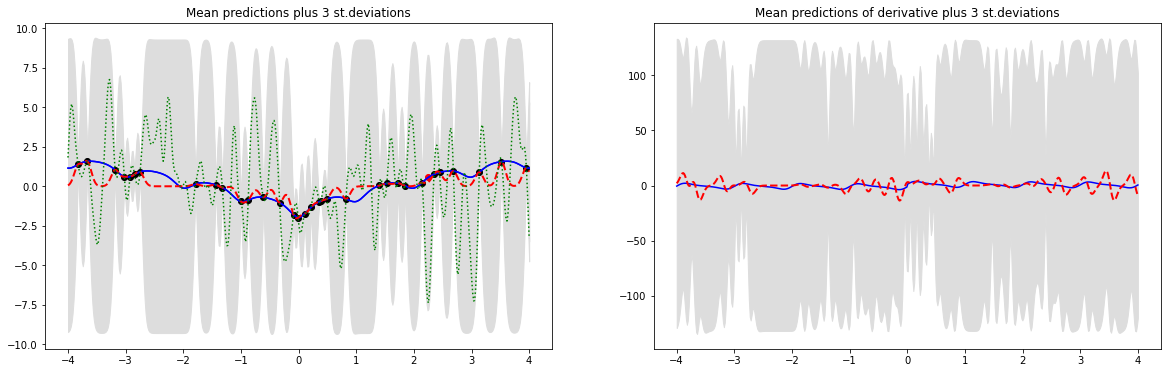

w:  [2.25250501]


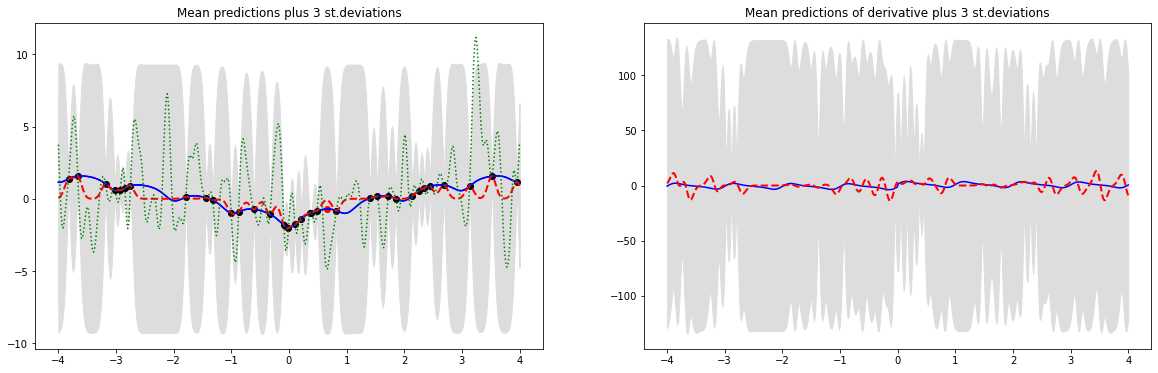

w:  [0.66533066]


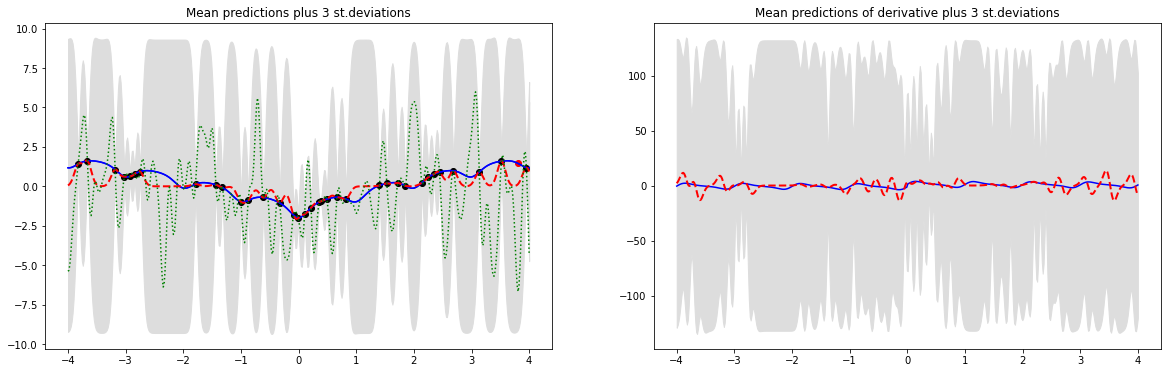

w:  [3.80761523]


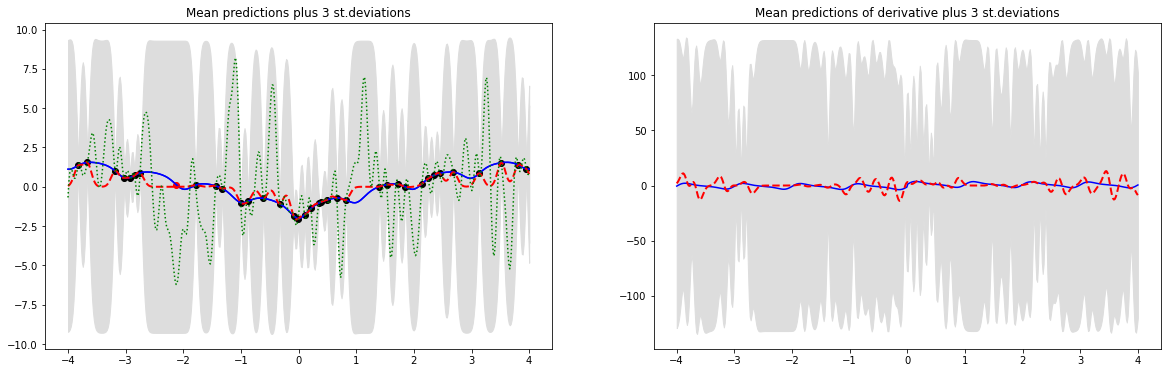

w:  [-2.1242485]


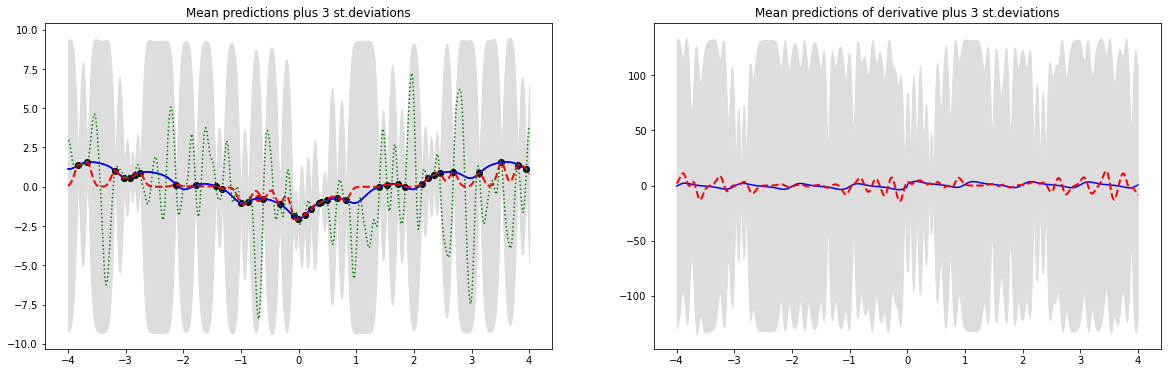

w:  [-0.69739479]


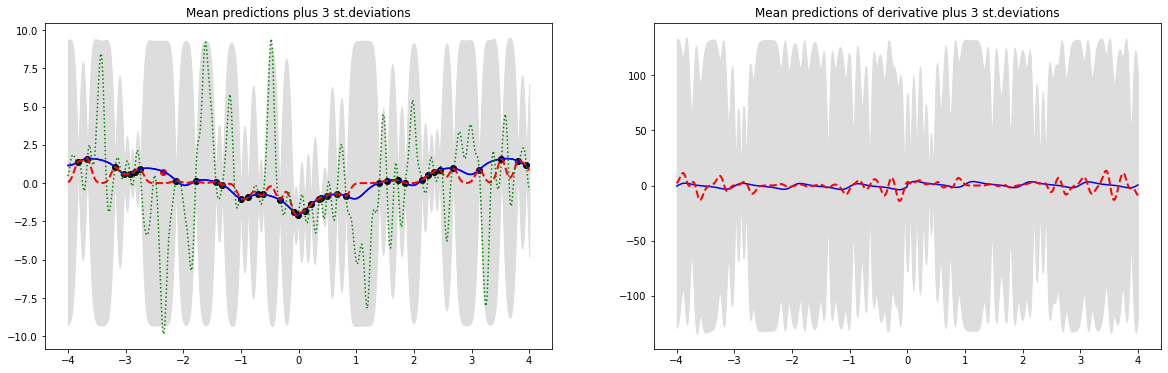

w:  [-2.34869739]


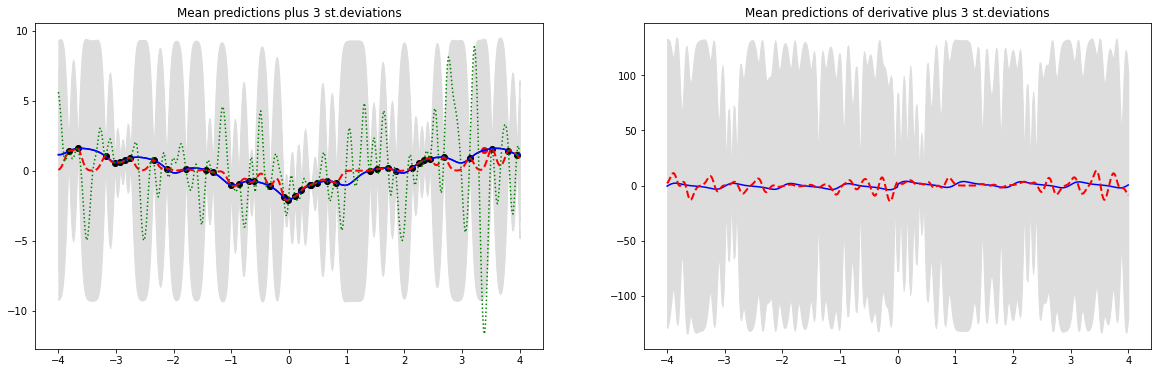

w:  [3.39078156]


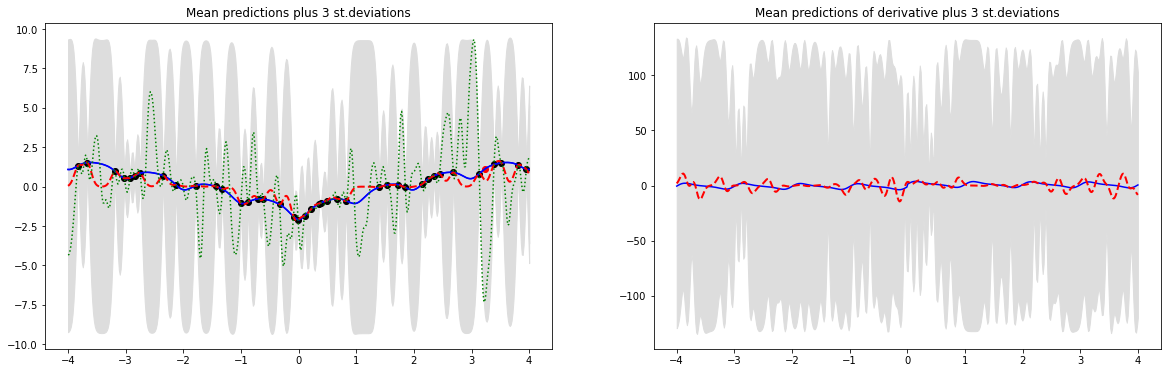

w:  [3.23046092]


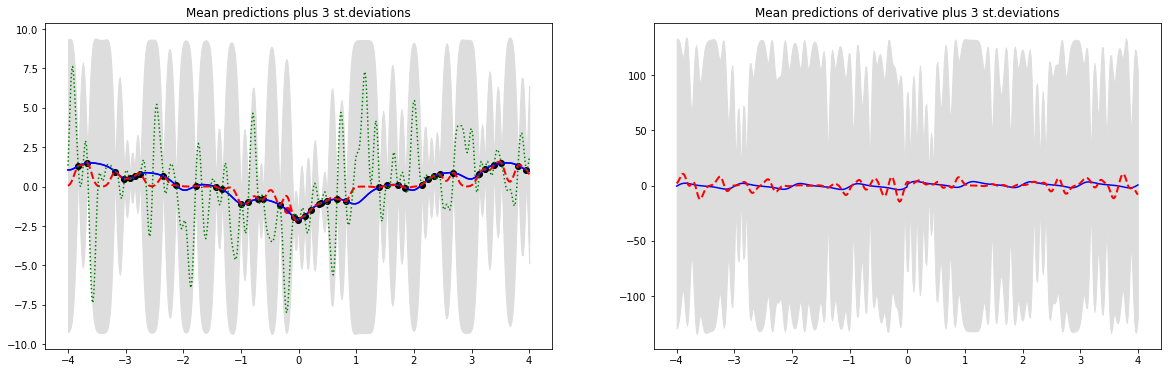

w:  [-0.2004008]


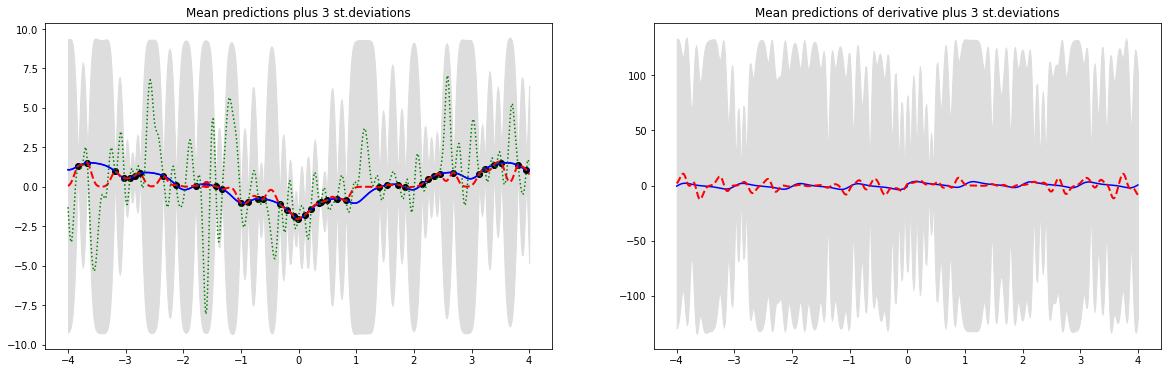

w:  [-1.61122244]


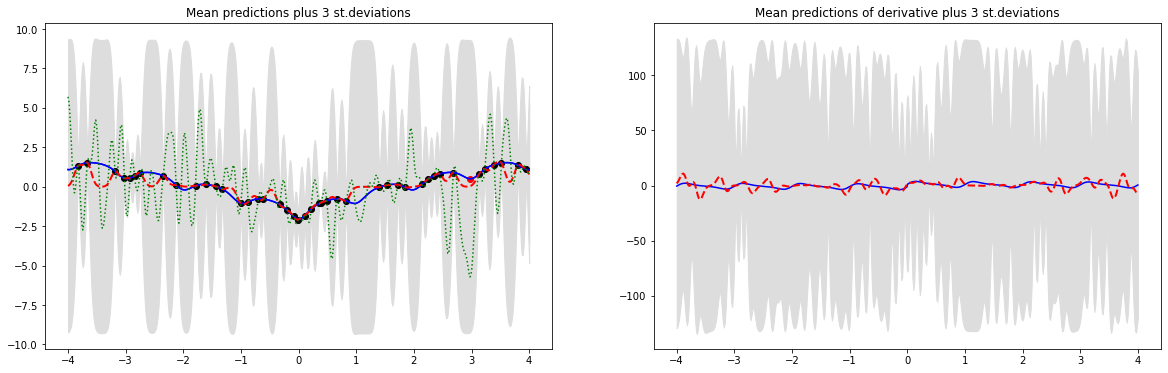

w:  [2.9739479]


In [23]:
gp.clear()
gp.set_hyper(ls, var)
gp.set_data(X, f(X))
gp.fit()

n_iter = 40
history = []

w = X[0].reshape(-1, 1)

for i in range(1,  n_iter):
    # posterior of GP given gp.X, gp.y
    mu, covar = gp.posterior(Grid)
    mu = np.squeeze(mu)
    s = np.sqrt(np.diag(covar))

    # posterior of GP derivative given gp.X, gp.y
    mu_grad, covar_grad = gp.posterior_grad(Grid)
    mu_grad = np.squeeze(mu_grad)
    s_grad = np.sqrt(np.diag(covar_grad))
    
    # joint MVN
    K = gp.cov_RBF(gp.X, gp.X, gp.get_hyper())
    K_ = gp.cov_RBF(Grid, Grid, gp.get_hyper())
    K_11 = gp.K11(Grid)
    K_01 = gp.K01(Grid)
    
    L = np.linalg.cholesky(covar + 1e-6*np.eye(n_Grid)) # LL^T = Sigma (posterior covariance)
    f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n_Grid, dim)))
    arg_min = np.argmin(f_post)
    w = Grid[arg_min]
    
    fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(20, 6))

    # plot function    
    ax1.plot(gp._X, gp._y, 'ko')
    ax1.plot(w, gp._normal(f(w)), 'ro')
    
    ax1.plot(Grid.flat, gp._normal(clean_f(Grid)), 'b-')
    ax1.fill_between(Grid.flat, mu-2*s, mu+2*s, color="#dddddd")
    
    ax1.plot(Grid.flat, gp._normal(clean_f(Grid)), 'b-')
    ax1.fill_between(Grid.flat, mu-2.576*s, mu+2.576*s, color="#dddddd")
    ax1.plot(Grid, mu, 'r--', lw=2)
    ax1.plot(Grid.flat, f_post, 'g:')
    ax1.set_title('Mean predictions plus 3 st.deviations')
#     ax1.axis([-5, 15, -3, 3])


    # plot derivative
    # pl.plot(X, y, 'r+', ms=7)
    ax2.fill_between(Grid.flat, mu_grad-2.576*s_grad, mu_grad+2.576*s_grad, color="#dddddd")
    ax2.plot(Grid.flat, gp._normal_grad(approx_grad), 'b-')
    ax2.plot(Grid.flat, mu_grad, 'r--', lw=2)
    ax2.set_title('Mean predictions of derivative plus 3 st.deviations')
#     ax2.axis([-5, 15, -3, 3])
    
#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     pl.savefig('Result_Plots/' + filename)
    pl.show()  
    
    print('w: ', w)
    history.append( f(w) )
    gp.add_data(w, f(w))
    gp.fit()

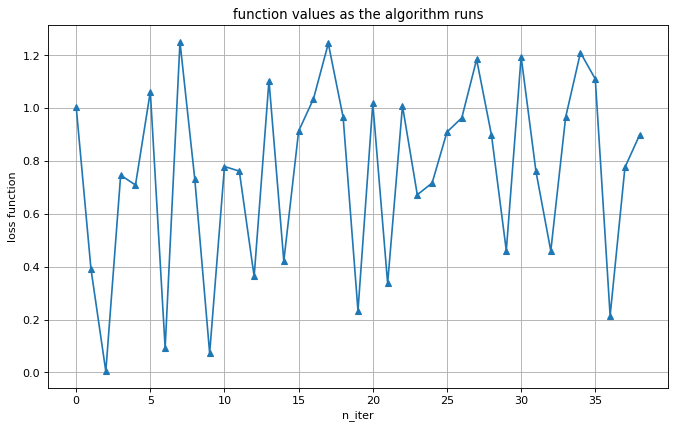

In [24]:
pl.figure(figsize=(10, 6), dpi=80)
pl.plot(np.squeeze(history), "-^")
pl.title("function values as the algorithm runs")
pl.xlabel("n_iter")
pl.ylabel("loss function")
pl.grid(True)

In [25]:
# # Creates the .gif from the saved plots for the 2D_Plots dir.
# filenames = []
# for i in range(1, n_iter):
#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     filenames.append(filename)

# frames=[]
# for filename in filenames:
#     frames.append(imageio.imread('Result_Plots/' + filename))
# exportname = 'Ackley_noise.gif'

# kargs = { 'duration': 0.5 }
# imageio.mimsave(exportname, frames, 'GIF', **kargs)